Visualize a subset of the OCT dataset provided by [tia16].

### References

[tia16]  Tian et al. "Performance evaluation of automated segmentation software on optical coherence tomography volume data," J. Biophotonics, 2016.   http://onlinelibrary.wiley.com/doi/10.1002/jbio.201500239/full

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import h5py
from functools import partial

import numpy as np
import pylab as plt
from scipy.io import loadmat

import train_oct

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def render_slice(x, y, layer_ids, layer_names, overlay=None):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'tan'] * 2
    layers = []
    
    if np.mean(y[y>0]) > x.shape[0] / 2.:
        loc = 'upper right'
    else:
        loc = 'lower right'
    
    fig = plt.figure(figsize=(8,8))
    plt.imshow(x, interpolation='none', cmap='bone')
    if overlay is not None:
        plt.imshow(overlay, interpolation='none', cmap='Set1', alpha=.4)
    for ii in range(y.shape[0]):
        if np.all(y[ii,:] > 0):
            plt.plot(np.arange(y.shape[1]), y[ii,:], colors[ii])
            layers.append(layer_ids[ii]) # numbering convention in [tia16] is 1-based
    
    plt.xlim([0, x.shape[1]]); plt.ylim([x.shape[0],0])
    plt.axis('off')
    
    lstr = [ '%d : %s' % (x, layer_names[x]) for x in layers]
    plt.legend(lstr, loc=loc)
    
    
    
def flatten_tensor(X, n_cols=10):
    n_slices = X.shape[0]
    m = int(np.ceil(n_slices / n_cols))
    
    X_flat = np.zeros((X.shape[1]*m, X.shape[2]*n_cols))
    for jj in range(n_cols):
        for ii in range(m):
            s = jj * m + ii
            if s > n_slices:
                break
                
            X_flat[(ii*X.shape[1]):((ii+1)*X.shape[1]),
                   (jj*X.shape[2]):((jj+1)*X.shape[2])] = X[s,:,:]
  
    return X_flat

X:  (50, 496, 768) uint8 0 255
Y:  (50, 9, 768) float64

percentage labeled of each boundary:
[ 100.  100.  100.    6.  100.   18.    2.  100.    0.]
[ 100.  100.  100.    0.  100.    0.    0.  100.    0.]


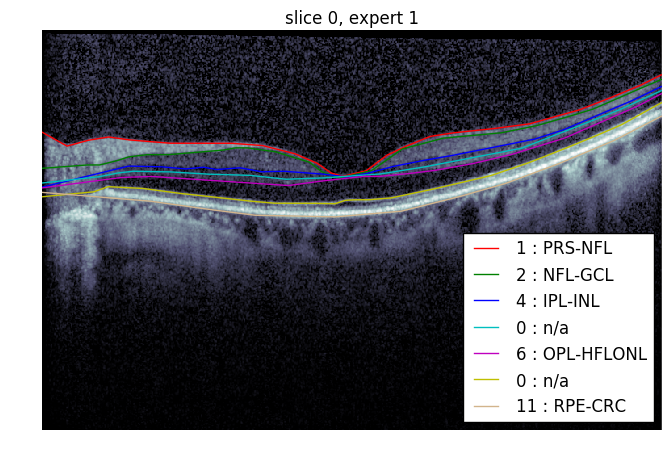

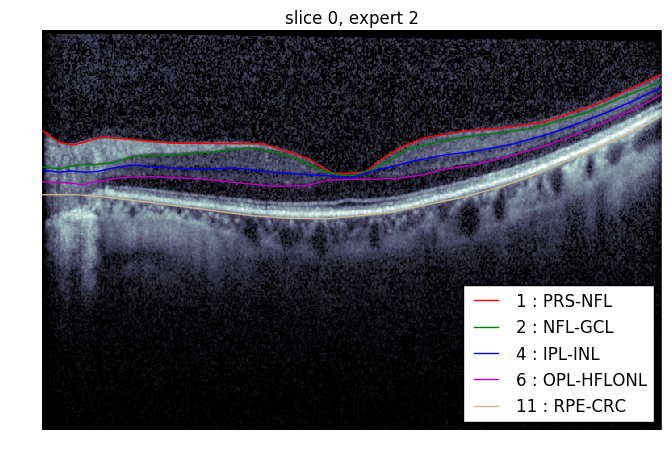

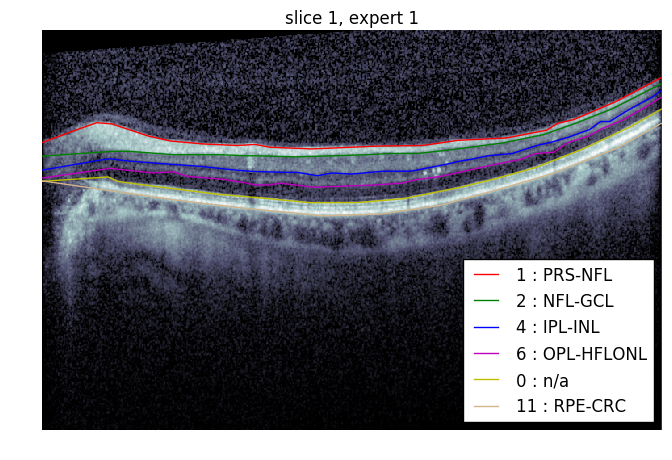

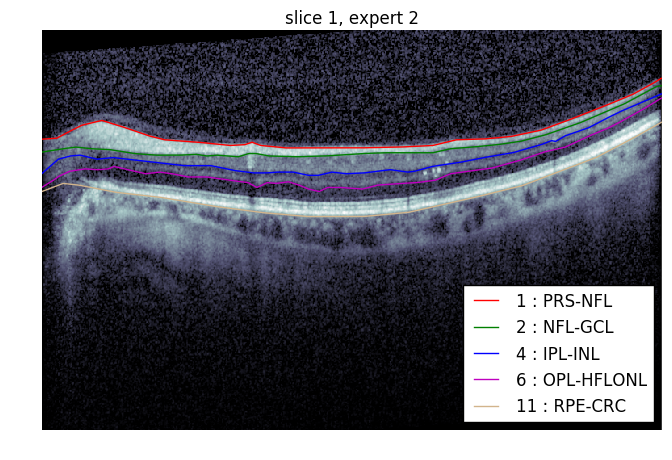

In [9]:
mat_file = '/Users/pekalmj1/Data/Tian_OCT/jbio201500239-sup-0003-Data-S1.mat'

X, Y1, Y2, fold_id = train_oct.tian_load_data(mat_file)


# See Table 2 and  section 2.5.3 in [tia16].
# Note the authors start counting at 1 and in python we start at 0.
layer_ids = [1, 2, 4, 0, 6, 0, 0, 11, 0] 
layer_names = ['n/a', # there is no layer 0
               'PRS-NFL', 'NFL-GCL', 'GCL-IPL', 'IPL-INL', 'INL-OPL',
               'OPL-HFLONL', 'HFLONL-ELMMYZ', 'ELMMYZ-ELZOS',
               'ELZOS-IDZ', 'IDZ-RPE', 'RPE-CRC']

plot_slice = partial(render_slice, layer_ids=layer_ids, layer_names=layer_names)

print('X: ', X.shape, X.dtype, np.min(X), np.max(X))
print('Y: ', Y1.shape, Y1.dtype)

pct_labeled_1 = 100. * np.sum(np.sum((Y1!=0),axis=2),axis=0) / Y1.shape[0] / Y1.shape[-1]
pct_labeled_2 = 100. * np.sum(np.sum((Y2!=0),axis=2),axis=0) / Y2.shape[0] / Y2.shape[-1]
print('\npercentage labeled of each boundary:')
print(pct_labeled_1)
print(pct_labeled_2)


# visualize a few annotations
for s in [0,1]:
    plot_slice(X[s,:,:], Y1[s,:,:])
    plt.title('slice %d, expert 1' % s)
    plt.show()

    plot_slice(X[s,:,:], Y2[s,:,:])
    plt.title('slice %d, expert 2' % s)
    plt.show()

In [ ]:
X_flat = flatten_tensor(X)

plt.figure(figsize=(12,12))
plt.imshow(X_flat, interpolation='none', cmap='bone')
plt.axis('off')
plt.title('all images')
plt.show()

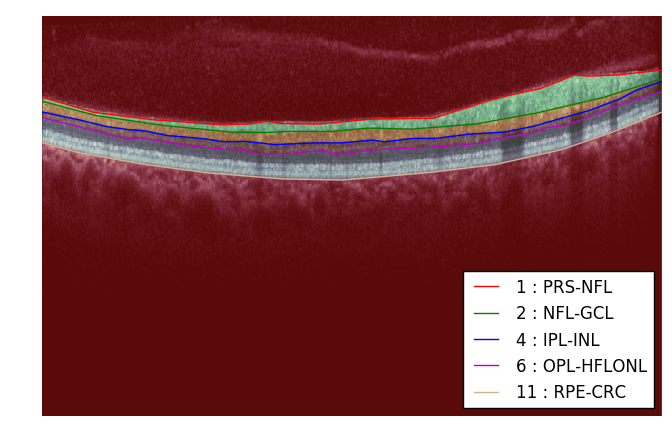

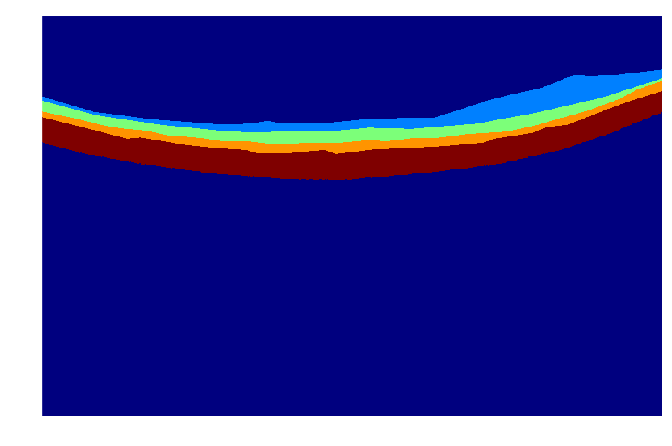

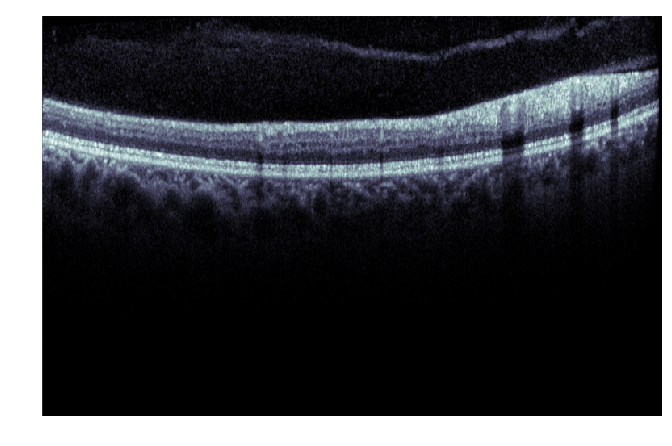

In [6]:
Y1_dense = train_oct.tian_dense_labels(Y1, X.shape[1])

# show labels overlaid on X
s = 15
plot_slice(X[s,:,:], Y1[s,:,:], overlay=Y1_dense[s,:,:])


# also show just labels
plt.figure(figsize=(8,8))
plt.imshow(Y1_dense[s,:,:], interpolation='none')
plt.axis('off')

plt.figure(figsize=(8,8))
plt.imshow(X[s,:,:], interpolation='none', cmap='bone')
plt.axis('off')

plt.show()

(50, 496, 768) (50, 100, 768)
(50, 1, 496, 768) (50, 1, 100, 768)


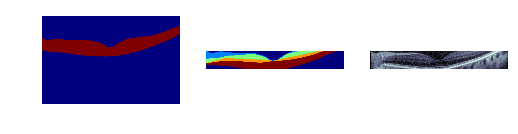

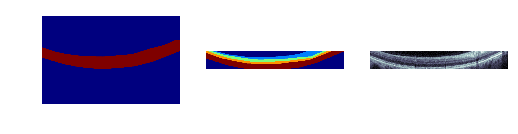

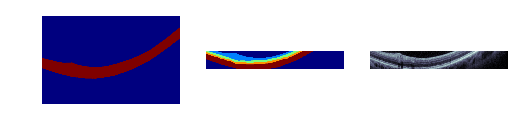

In [104]:
# Investiate possible vertical crops

crops = train_oct.tian_find_crops(Y1_dense > 0, .2)
Y1_cropped = train_oct._crop_rows(Y1_dense, crops)

X_4d = X[:,np.newaxis,:,:]
X_cropped = train_oct._crop_rows(X_4d, crops)

print(Y1_dense.shape, Y1_cropped.shape)
print(X_4d.shape, X_cropped.shape)


for s in [0, 5, 10]:
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(Y1_dense[s,...] > 0)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(Y1_cropped[s,...])
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(X_cropped[s,0,...], cmap='bone')
    plt.axis('off')
    
    plt.show()